# Exemple de l'utilisation du package backtest

Ce notebook vise à aider l'utilisateur de ce package à mettre en oeuvre ses propres backtests sur des stratégies qu'il a lui-même créées. Les codes des exemples de stratégie sont disponibles dans le fichier "example_strategies.py".

## 1. Imports des packages et des données

Tout d'abord, on procède à quelques imports usuels, en plus du téléchargement du backtester

In [1]:
%pip install pandas numpy matplotlib seaborn plotly backtest==0.1.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
# On ajoute le dossier parent (Backtesting) au PYTHONPATH
import sys
import os
sys.path.append(os.path.abspath("../"))

# Import de la classe Backtest et des autres bibliothèques usuelles
from backtest.backtest import Backtest as bt
from backtest.strategy import Strategy
import pandas as pd
import numpy as np


On récupère ensuite le fichier CSV contenant l'historique des prix des actifs composant le portefeuille, en s'assurant que les valeurs sont traitables. On met immédiatement en index les dates de l'historique.

In [3]:
current_dir = os.getcwd()
historical_data_file = os.path.join(current_dir, "utils", "Cac40.csv")

df = pd.read_csv(historical_data_file, delimiter=';', index_col="Date")
df.index = pd.to_datetime(df.index, dayfirst=True)

if df.isnull().values.any():
    raise ValueError("Les données contiennent des valeurs nulles.")
if not np.isfinite(df.values).all():
    raise ValueError("Les données contiennent des valeurs infinies.")

## 2. Mise en oeuvre du backtest

Le backtester permet d'obtenir un certain nombre de statistiques diverses permettant d'évaluer différentes stratégies d'investissement. Il offre aussi plusieurs éléments de visualisation, notamment sur l'évolution de la valeur du portefeuille. Il tient compte de rebalancements effectués à une fréquence donnée, et de la présence possible d'une fenêtre de calcul, autrement dit d'un nombre fixé de données historiques à conserver pour le calcul des positions. Par souci de clareté, les tailles des périodes de rebalancement et des fenêtres de calcul doivent être exprimées dans la même unité que les données : par exemple, si une fenêtre de calcul de 8 est reseignée, cela correspondra à 8 jours, semaines ou mois selon la périodicité des données. Le backtester gère également les frais de transaction, supposés proportionnels au noiombre de trades. 

Les stratégies doivent nécessairement avoir un argument concernant la fenêtre de calcul. De plus, lors de l'appel de la fonction `get_position`, des données historiques et les positions actuelles sont à indiquer. Tout cela est pris en compte dans le backtester, mais il est nécessaire que les stratégies créées héritent de la classe abstraite `Strategy` pour que cela fonctionne. Finalement, le lancement du backtester nécessite : 
- la création d'une instance de la classe `Backtest` avec comme arguments le dataframe des prix des actifs du portefeuille, l'instance de la stratégie, la fréquence de rebalancement, la valeur initiale du portefeuille et les coûts de transaction,
- l'appel de la fonction `execute_backtest` en renseignant les valeurs du taux sans risque et du *minimum average return*, ainsi que l'outil souhaité pour les graphiques : `matplotlib`, `seaborn` ou `plotly`.

In [4]:
# Constantes
TRANSACTION_COST = 0.001

### Stratégie Momentum

Un portefeuille momentum repose sur une stratégie d’investissement qui consiste à être $\textit{long}$ des actifs dont les prix montent (actifs performants) être $\textit{short}$ des actifs dont les prix baissent (actifs sous-performants). L’idée sous-jacente est que les tendances passées vont se poursuivre à court ou moyen terme, exploitant ainsi l’inertie des mouvements de marché. Dans notre exemple, une instance de la classe `Momentum` s'initialise à partir de quatre arguments : 
- la taille de la fenêtre de calcul sur laquelle se base la stratégie pour déterminer les titres qui progressent et ceux qui baissent (un entier),
- le nombre d'actifs souhaité dans le portefeuille (un entier),
- l'autorisation ou non de la vente à découvert (un booléen),
- l'équipondération ou non du portefeuille (un booléen). Dans le cas où le portefeuille n'est pas equipondéré, plus un actif est performant sur la fenêtre de calcul et plus le poids qui lui sera accordé sera grand. 

In [5]:
from example_strategies import Momentum
momentum_strategy = Momentum(52, 10, True, False)
backtest_momentum: bt = bt(data=df, strategy=momentum_strategy, frequence_rebalancement=16, initial_value= 100.0, transaction_cost=TRANSACTION_COST)
backtest_momentum.execute_backtest(risk_free_rate=0.03, mar=0.04, backend="plotly")

Performance totale: 256.79%
Performance annualisée: 8.09%
Volatilité annualisée: 39.27%
Ratio de Sharpe: 0.13
Ratio de Sortino: 2.60
Max Drawdown: -82.80%
Nombre de trades: 746
Pourcentage de trades gagnants: 48.12%


Dans l'exemple ci-dessus, nous considérons une période de calcul de 52 semaines, et une fréquence de rebalancement de 16 semaines. Toutes les 16 semaines les titres qui ont le mieux performé sur l'année écoulée auront les poids les plus importants. 

Mais si l'on considère des périodes de calcul plus courtes, cette stratégie offre des résultats plus décevants que ceux ci-dessus. Prenons l'exemple d'une fenêtre de calcul de 32 semaines. 

In [6]:
momentum_strategy = Momentum(32, 20, True, False)
backtest_momentum_bis: bt = bt(data=df, strategy=momentum_strategy, frequence_rebalancement=16, initial_value= 100.0, transaction_cost=TRANSACTION_COST)
backtest_momentum_bis.execute_backtest(risk_free_rate=0.03, mar=0.04, backend="plotly")

Performance totale: -15.30%
Performance annualisée: -0.99%
Volatilité annualisée: 32.31%
Ratio de Sharpe: -0.12
Ratio de Sortino: -4.37
Max Drawdown: -82.01%
Nombre de trades: 1461
Pourcentage de trades gagnants: 48.05%


### Stratégie Trend Following

Un portefeuille trend following repose sur une stratégie d’investissement qui vise à exploiter les tendances des marchés en ajustant les positions en fonction des mouvements des prix sur différentes périodes. Cette approche repose sur l’idée que les actifs ayant une tendance positive récente continueront à monter, tandis que ceux ayant une tendance négative continueront à baisser. Cette stratégie est donc proche des stratégies Momentum, mais présente quelques différences. La stratégie combine des signaux à court, moyen et long termes pour déterminer les positions optimales. Ces signaux peuvent avoir des poids plus ou moins importants. De plus cette stratégie ne considère pas l'ampleur de la performance des titres mais seulement le signe de leurs rendements : si les rendements sont positifs,  ces titres sont achetés, et ils sont vendus dans le cas contraire. Dans notre exemple, une instance de la classe `TrendFollowing` s'initialise à partir de quatre arguments :
- la taille de la fenêtre de calcul (un entier),
- le coefficient associé aux rendements à court terme (un flottant),
- le coefficient associé aux rendements à moyen terme (un flottant),
- le coefficient associé aux rendements à long terme (un flottant).

In [7]:
from example_strategies import TrendFollowing
trend_strategy = TrendFollowing(36, 4, 1, 1)
backtest_trend : bt = bt(data=df, strategy=trend_strategy, frequence_rebalancement=16, initial_value= 100.0, transaction_cost=TRANSACTION_COST)
backtest_trend.execute_backtest(risk_free_rate=0.03, mar=0.04, backend="plotly")

Performance totale: 141.64%
Performance annualisée: 5.43%
Volatilité annualisée: 27.25%
Ratio de Sharpe: 0.09
Ratio de Sortino: 2.96
Max Drawdown: -70.44%
Nombre de trades: 1958
Pourcentage de trades gagnants: 53.06%


### Stratégie Value

Un portefeuille **Value** est un portefeuille qui est *long* sur les actifs *cheap* et *short* sur les actifs *expensive*. Cela revient à exploiter les phénomènes de ***mean reversion***, cherchant à lutter contre les exagérations de marché. Pour mesurer si un actif est *cheap*, il faut comparer son prix à ce qu'il rapporte. La mesure de la cherté est laissée à la discrétion de l'utilisateur. Dans notre exemple, nous utilisons le PER. Concrètement, un actif dont le dernier PER en date est supérieur au PER moyen sur la période de calcul considéré sera jugé trop cher et nous le vendrons. L'inverse est fait si le PER final est inférieur au PER moyen.

La stratégie Value peut se voir comme l'opposé (ou le complémentaire) de la stratégie Momentum. On parie sur des titres qui sont délaissés par marché (les titres *cheap*), alors que Momentum parie sur les titres très prisés par le marché. Ces deux stratégies sont donc souvent combinées pour diversifier le risque.

 Dans notre exemple, une instance de la classe `Value` s'initialise à partir de quatre arguments : 
- un DataFrame contenant les données de PER pour chaque actif,
- la taille de la fenêtre de calcul (un entier),
- l'autorisation ou non de la vente à découvert (un booléen),
- l'équipondération ou non du portefeuille (un booléen).  

In [8]:
from example_strategies import Value
PER_data = pd.read_csv("utils/PER.csv", delimiter = ";", na_values = "#N/A", index_col = "Dates")
PER_data.index = pd.to_datetime(PER_data.index , dayfirst=True)

value_strategy = Value(PER_data, 24, True)
backtest_value : bt = bt(data=df, strategy=value_strategy, frequence_rebalancement=8, initial_value= 100.0, transaction_cost=TRANSACTION_COST)
backtest_value.execute_backtest(risk_free_rate=0.03, mar=0.04, backend="plotly")

Performance totale: 214.12%
Performance annualisée: 7.01%
Volatilité annualisée: 33.01%
Ratio de Sharpe: 0.12
Ratio de Sortino: 3.36
Max Drawdown: -63.48%
Nombre de trades: 3257
Pourcentage de trades gagnants: 51.37%


### Stratégie factorielle : Fama-French à 3 facteurs 

Un portefeuille Fama-French repose sur une stratégie d’investissement factorielle qui exploite les expositions des actifs à des facteurs systématiques tels que la prime de marché, la taille des entreprises, et la valorisation. Cette approche repose sur l’idée que les rendements des actifs sont influencés par leur sensibilité ($\beta$) à ces facteurs. Ici, nous considérons les facteurs définis dans le modèle à 3 facteurs de Fama & French. La stratégie ajuste les positions en fonction des $\beta$ estimés pour cibler une exposition spécifique à ces facteurs. Ainsi, on achètera les actifs en moyenne sur-exposés au facteur souhaité, et vendra les actifs en moyenne sous-exposés au facteur considéré. 

Dans notre exemple, une instance de la classe FamaFrench s'initialise à partir de quatre arguments :
- un DataFrame contenant les données historiques des facteurs de Fama et French (nous considérons ceux européens, disponibles sur le site de Kenneth R. French),
- la taille de la fenêtre de calcul (un entier),
- une méthode d’investissement parmi les options disponibles (un énumérateur, de la classe `Method`),
- l'autorisation ou non de la vente à découvert (un booléen),

Pour les besoins de la visualisation, nous considérons un portefeuille fortement exposé au facteur *size*, `SMB`.

In [9]:
from example_strategies import Method, FamaFrench

FF_factors = pd.read_csv("utils/FamaFrenchFactors.csv", delimiter = ";", na_values = "#N/A")
FF_strategy_SMB = FamaFrench(FF_factors, 12, Method.BETA_SMB)
backtest_FF_SMB : bt = bt(data=df, strategy=FF_strategy_SMB, frequence_rebalancement=8, initial_value= 100.0, transaction_cost=TRANSACTION_COST)
backtest_FF_SMB.execute_backtest(risk_free_rate=0.03, mar=0.04)

Performance totale: 74.35%
Performance annualisée: 3.30%
Volatilité annualisée: 30.78%
Ratio de Sharpe: 0.01
Ratio de Sortino: -0.80
Max Drawdown: -67.09%
Nombre de trades: 3974
Pourcentage de trades gagnants: 49.77%


## 3. Comparaison des stratégies

Le backtester fournit également un moyen direct de comparer les stratégies. Il est en effet naturel de vouloir implémenter diverses stratégies et comparer leurs statistiques de performance pour finalement faire son choix. Dans le cas de portefeuilles multi-stratégies, il peut être utile de connaître les corrélations entre les différentes stratégies, notamment si l'on souhaite réduire le risque en utilisant des stratégies peu corrélées, voire corrélées négativement. Finalement, l'évolution du drawdown pour chaque stratégie est aussi un élément pertinent comme mesure du risque des stratégies et de leur souffrance en période difficile. Par soucis de comparaison, on considère les mêmes taux sans risque, *minimum acceptable return* et frais de transaction pour les quatre stratégies.   

In [10]:
from backtest.result import Result

result_momentum = Result(backtest_momentum, 0.03, 0.04)
result_trend = Result(backtest_trend, 0.03, 0.04)
result_value = Result(backtest_value, 0.03, 0.04)
result_FF_SMB = Result(backtest_FF_SMB, 0.03, 0.04)


Comparaison des performances :

                 Performance totale  Performance annualisée  Volatilité  \
Momentum                   2.567939                0.080915    0.392703   
Trend Following            1.416371                0.054339    0.272518   
Value                      2.141151                0.070058    0.330086   
FamaFrench-SMB             0.743546                0.032979    0.307821   

                 Ratio de Sharpe  Ratio de Sortino  Max Drawdown  
Momentum                0.129654          2.596859     -0.827971  
Trend Following         0.089312          2.964251     -0.704433  
Value                   0.121357          3.357744     -0.634771  
FamaFrench-SMB          0.009677         -0.799816     -0.670914  


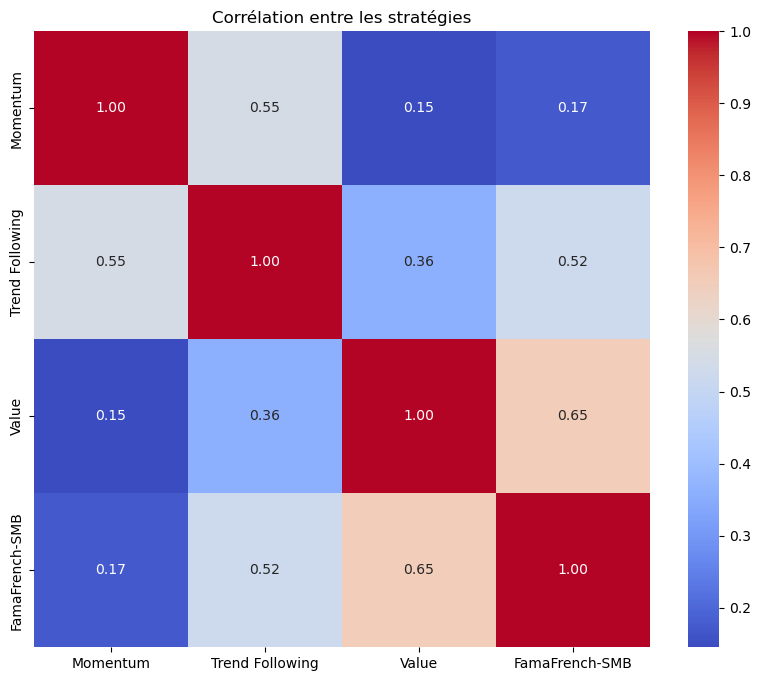

In [11]:
Result.compare_results(result_momentum, result_trend, result_value, result_FF_SMB,
                       strategy_names=["Momentum", "Trend Following", "Value", "FamaFrench-SMB"],
                       backend = "plotly")


Ces graphiques permettent de visualiser divers éléments pertinents à la décision stratégique. 

Tout d'abord, on constate sur le graphique "Couple rendement - risque pour chaque stratégie" que la stratégie visant à acheter les portefeuilles les plus exposés au facteur *size* de la stratégie Fama French est dominée par la stratégie Trend Following, qui offre un rendement supérieur pour un risque moindre. Les trois autres stratégies présentent quant à elles les attributs classiques d'un couple rendement / risque : le rendement augmente, au prix d'une volatilité accrue. 

Ensuite, si la stratégie Momentum est la plus risquée, sa performance annualisée est telle qu'elle offre finalement le meilleur ratio de Sharpe. La stratégie Value est non loin derrière. La stratégie Trend Following se classe troisième en terme de ratio de Sharpe tandis que la stratégie Fama - French - SMB ferme la marche. Si l'on regarde le ratio de Sortino, qui ne considère que la volatilité des rendements négatifs, alors c'est Value qui est la meilleure stratégie. Cela traduit le fait qu'un portefeuille Value repose précisément sur des valeurs stables, qui résistent bien dans un contexte morose général.  

La matrice de corrélation entre les différentes stratégies met en évidence des relations intéressantes entre elles : 
- les stratégies Momentum et Trend Following présentent une corrélation relativement élevée (0,55). Malgré leurs différences (Momentum se concentre davantage sur la vitesse et la direction des mouvements de prix à court terme, tandis que Trend Following s'oriente sur des horizons plus longs), elles conservent une nature similaire (exploiter les tendances de marché), expliquant ainsi une telle corrélation ; 
- la stratégie Value a une corrélation très faible avec Momentum (0,15), car elle repose sur des principes fondamentalement différents. Alors que Momentum suit les tendances actuelles, Value cherche des actifs sous-évalués selon des fondamentaux, souvent contraires aux tendances du marché. 
- la stratégie Value a une corrélation modérée avec Trend Following (0,36). Elle est plus elevée qu'entre Value et Momentum, ce qui caractérise une nouvelle fois le côté plus "long termiste" de Trend Following par rapport à Momentum.
- la stratégie basée sur le facteur Fama-French SMB montre une corrélation élevée avec Value (0,65), reflétant le fait que les deux s'appuient sur des critères de sélection fondés sur des caractéristiques fondamentales des entreprises (taille ou valorisation), mais une corrélation faible avec Momentum (0,17) pour les mêmes raisons qu'entre Momentum et Value. 

Ainsi, si l'on devait choisir deux stratégies avec des considérations de risque, *ceteris paribus*, on constiturait probablement un portefeuille de type Value & Momentum. 

L'étude des drawdowns, finalement, permet d'observer le risque des stratégies sous un nouvel angle : à chaque date, on considère le drawdown par rapport au maximum historique à cette date. Ce que nous enseigne ce graphique, c'est que les stratégies Momentum et Trend Following souffrent en moyenne plus fortement et plus longtemps que les stratégies Value et Fama French - SMB, ce qui est parfaitement cohérent avec les caractéristiques même des stratégies : Momentum et Trend Following exposent davantage l'investisseur à des risques de drawdowns profonds en cas de retournement brutal, alors que Value et Fama French - SMB affichent une meilleure robustesse face aux périodes difficiles, reflétant leur nature défensive. 